In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
from sklearn import cross_decomposition
from sklearn.model_selection import KFold

from neural_regression.datasets.Lieber_V4 import LieberV4
from neural_regression.datasets.transforms import LieberV4_ImageNet_Transform 
from neural_regression.datasets.FreemanZiemba_V1V2 import FreemanZiembaV1V2
from neural_regression.datasets.transforms import FreemanZiembaV1V2_ImageNet_Transform
from neural_regression.models.alexnet import get_alexnet_model
from neural_regression.regression.activations import get_activations

In [2]:
# get models
alexnet_random = get_alexnet_model("random")
alexnet_supervised = get_alexnet_model("supervised")
alexnet_robust = get_alexnet_model("robust")

# create datasets and dataloaders
dataset_V1 = FreemanZiembaV1V2(
    brain_area="V1",
    image_transform = FreemanZiembaV1V2_ImageNet_Transform(),
)
dataset_V2 = FreemanZiembaV1V2(
    brain_area="V2",
    image_transform = FreemanZiembaV1V2_ImageNet_Transform(),
)
dataset_V4 = LieberV4(
    image_transform = LieberV4_ImageNet_Transform(),
)

dataloader_V1 = torch.utils.data.DataLoader(
    dataset_V1, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4,
)
dataloader_V2 = torch.utils.data.DataLoader(
    dataset_V2, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4,
)
dataloader_V4 = torch.utils.data.DataLoader(
    dataset_V4, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4,
)

In [3]:
# define area specific layer mappings
random_layer_map = {
    "V1": "features.2",   
    "V2": "features.5",   
    "V4": "features.12",   
}
supervised_layer_map = {
    "V1": "features.2",   
    "V2": "features.5",   
    "V4": "features.12",   
}
robust_layer_map = {
    "V1": "features.4",   
    "V2": "features.5",   
    "V4": "features.12",   
}


In [4]:
# get activations and neural responses
activations_random_V1, neural_responses_V1, _ = get_activations(
    model = alexnet_random,
    loader = dataloader_V1,
    result_layers = [random_layer_map["V1"]],
    device = torch.device("cuda"),
)
activations_supervised_V1, _, _ = get_activations(
    model = alexnet_supervised,
    loader = dataloader_V1,
    result_layers = [supervised_layer_map["V1"]],
    device = torch.device("cuda"),
)
activations_robust_V1, _, _ = get_activations(
    model = alexnet_robust,
    loader = dataloader_V1,
    result_layers = [robust_layer_map["V1"]],
    device = torch.device("cuda"),
)

activations_random_V2, neural_responses_V2, _ = get_activations(
    model = alexnet_random,
    loader = dataloader_V2,
    result_layers = [random_layer_map["V2"]],
    device = torch.device("cuda"),
)
activations_supervised_V2, _, _ = get_activations(
    model = alexnet_supervised,
    loader = dataloader_V2,
    result_layers = [supervised_layer_map["V2"]],
    device = torch.device("cuda"),
)
activations_robust_V2, _, _ = get_activations(
    model = alexnet_robust,
    loader = dataloader_V2,
    result_layers = [robust_layer_map["V2"]],
    device = torch.device("cuda"),
)

activations_random_V4, neural_responses_V4, _ = get_activations(
    model = alexnet_random,
    loader = dataloader_V4,
    result_layers = [random_layer_map["V4"]],
    device = torch.device("cuda"),
)
activations_supervised_V4, _, _ = get_activations(
    model = alexnet_supervised,
    loader = dataloader_V4,
    result_layers = [supervised_layer_map["V4"]],
    device = torch.device("cuda"),
)
activations_robust_V4, _, _ = get_activations(
    model = alexnet_robust,
    loader = dataloader_V4,
    result_layers = [robust_layer_map["V4"]],
    device = torch.device("cuda"),
)

/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will 

In [5]:
def simple_score_pls(X, Y, n_splits=5, num_components=25, scale=False):
    # flatten X if needed
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        pls = cross_decomposition.PLSRegression(n_components=num_components, scale=scale)
        pls.fit(X_train, Y_train)

        preditions_test = pls.predict(X_test)
        corrs = [
            np.corrcoef(Y_test[:, i], preditions_test[:, i])[0, 1] 
            for i in range(Y.shape[1])
        ]
        scores.append(np.median(corrs))

    return scores


In [6]:
scores_random_V1 = simple_score_pls(
    X = activations_random_V1[random_layer_map["V1"]],
    Y = neural_responses_V1,
    n_splits = 5,
    num_components = 25,
    scale = False,
)
scores_supervised_V1 = simple_score_pls(
    X = activations_supervised_V1[supervised_layer_map["V1"]],
    Y = neural_responses_V1,
    n_splits = 5,
    num_components = 25,
    scale = False,
)
scores_robust_V1 = simple_score_pls(
    X = activations_robust_V1[robust_layer_map["V1"]],
    Y = neural_responses_V1,
    n_splits = 5,
    num_components = 25,
    scale = False,
)

scores_random_V2 = simple_score_pls(
    X = activations_random_V2[random_layer_map["V2"]],
    Y = neural_responses_V2,
    n_splits = 5,
    num_components = 25,
    scale = False,
)
scores_supervised_V2 = simple_score_pls(
    X = activations_supervised_V2[supervised_layer_map["V2"]],
    Y = neural_responses_V2,
    n_splits = 5,
    num_components = 25,
    scale = False,
)
scores_robust_V2 = simple_score_pls(
    X = activations_robust_V2[robust_layer_map["V2"]],
    Y = neural_responses_V2,
    n_splits = 5,
    num_components = 25,
    scale = False,
)

scores_random_V4 = simple_score_pls(
    X = activations_random_V4[random_layer_map["V4"]],
    Y = neural_responses_V4,
    n_splits = 5,
    num_components = 25,
    scale = False,
)
scores_supervised_V4 = simple_score_pls(
    X = activations_supervised_V4[supervised_layer_map["V4"]],
    Y = neural_responses_V4,
    n_splits = 5,
    num_components = 25,
    scale = False,
)
scores_robust_V4 = simple_score_pls(
    X = activations_robust_V4[robust_layer_map["V4"]],
    Y = neural_responses_V4,
    n_splits = 5,
    num_components = 25,
    scale = False,
)

In [9]:
print(np.mean(scores_robust_V1))
print(np.mean(scores_supervised_V1))
print(np.mean(scores_random_V1))
print()
print(np.mean(scores_robust_V2))
print(np.mean(scores_supervised_V2))
print(np.mean(scores_random_V2))
print()
print(np.mean(scores_robust_V4))
print(np.mean(scores_supervised_V4))
print(np.mean(scores_random_V4))
print()

0.5677032945719324
0.5227406678148203
0.5056752553349015

0.5408717187944054
0.5105128249212286
0.3792932361527678

0.4743868177661737
0.44662341764839775
0.4275614760920184



In [10]:
# build results dataframe for visualization
results_dict = {
    "Model": [],
    "Score": [],
    "Brain Area": []
}

for score in scores_robust_V1:
    results_dict["Model"].append("Robust")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V1")
for score in scores_supervised_V1:
    results_dict["Model"].append("Supervised")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V1")
for score in scores_random_V1:
    results_dict["Model"].append("Random")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V1")

for score in scores_robust_V2:
    results_dict["Model"].append("Robust")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V2")
for score in scores_supervised_V2:
    results_dict["Model"].append("Supervised")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V2")
for score in scores_random_V2:
    results_dict["Model"].append("Random")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V2")

for score in scores_robust_V4:
    results_dict["Model"].append("Robust")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V4")
for score in scores_supervised_V4:
    results_dict["Model"].append("Supervised")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V4")
for score in scores_random_V4:
    results_dict["Model"].append("Random")
    results_dict["Score"].append(score)
    results_dict["Brain Area"].append("V4")

results_df = pd.DataFrame(results_dict)

Text(0.5, 0, 'Model')

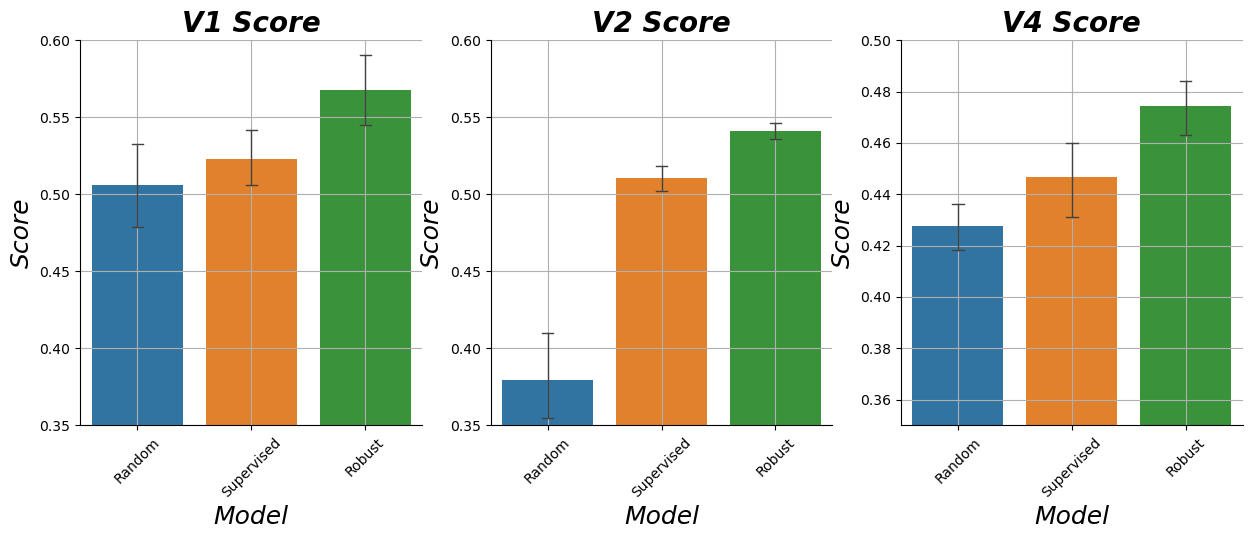

In [17]:
# bar plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

sns.barplot(
    data=results_df[results_df["Brain Area"] == "V1"],
    x="Model",
    y="Score",
    ax=axs[0],
    capsize=0.1,
    errwidth=1.0, 
    order=["Random", "Supervised", "Robust"],
)
sns.barplot(
    data=results_df[results_df["Brain Area"] == "V2"],
    x="Model",
    y="Score",
    ax=axs[1],
    capsize=0.1,
    errwidth=1.0, 
    order=["Random", "Supervised", "Robust"],
)
sns.barplot(
    data=results_df[results_df["Brain Area"] == "V4"],
    x="Model",
    y="Score",
    ax=axs[2],
    capsize=0.1,
    errwidth=1.0, 
    order=["Random", "Supervised", "Robust"],
)


# turn off top and right spines
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # tilt x-axis tick labels
    ax.tick_params(axis='x', rotation=45)

    ax.grid('True')


axs[0].set_title("V1 Score", fontsize=20, fontweight='semibold', fontstyle='italic')
axs[1].set_title("V2 Score", fontsize=20, fontweight='semibold', fontstyle='italic')
axs[2].set_title("V4 Score", fontsize=20, fontweight='semibold', fontstyle='italic')

axs[0].set_ylim(0.35, 0.6)
axs[1].set_ylim(0.35, 0.6)
axs[2].set_ylim(0.35, 0.5)

axs[0].set_ylabel("Score", fontsize=18, fontstyle='italic')
axs[1].set_ylabel("Score", fontsize=18, fontstyle='italic')
axs[2].set_ylabel("Score", fontsize=18, fontstyle='italic')

axs[0].set_xlabel("Model", fontsize=18, fontstyle='italic')
axs[1].set_xlabel("Model", fontsize=18, fontstyle='italic')
axs[2].set_xlabel("Model", fontsize=18, fontstyle='italic')

